# Building an Autoencoder using Pytorch
Introduction and Setup
In this lab, we will be building an autoencoder using Pytorch to compress and decompress images. The process includes:

1. Loading and preprocessing the dataset.
2. Implementing a simple Multi-Layer Perceptron (MLP)-based autoencoder.
3. Training the model and evaluating its performance.
4. Visualizing and interpreting the results.

Before we start, we need to import the necessary libraries.

# Importing Libraries
Here, we will import the libraries that we will use throughout the lab:

1. **PyTorch**: This is the core library we will use for building and training the neural network, including the model definition, loss functions, and optimization routines.
2. **TorchVision**: Provides utilities for loading and transforming image datasets, such as the MNIST dataset, and applying image transformations (e.g., resizing, normalizing).
3. **NumPy**: Used for handling numerical arrays, especially for dataset manipulation and when working with batch processing.
4. **Matplotlib**: Helps visualize the data, the reconstructed images, and the evaluation metrics (e.g., loss curves, PSNR, SSIM) during the training process.
5. **skimage.metrics**: Specifically, we import the `structural_similarity` function (SSIM) from this library to evaluate image quality based on the structural similarity index, which is a measure of image quality that compares the similarity between the original and the reconstructed images.
6. **os**: Used for handling file system operations like creating directories to store model checkpoints or outputs.


In [1]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim
import os

d:\Users\GEOMETREX\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading and Preprocessing the Dataset
In this step, we will load the MNIST dataset, which contains 28x28 pixel grayscale images of handwritten digits. This dataset is widely used for image processing tasks.

We'll load the dataset and apply the following preprocessing steps:
1. Convert the images to PyTorch tensors.
2. Resize the images to 128x128 pixels to match the model's expected input size.
3. Duplicate the single grayscale channel into three channels to adapt the dataset for models designed to process 3-channel (RGB) images.

These preprocessing steps ensure compatibility with the model architecture and improve training stability. We will then create data loaders for easy batch processing of the dataset.


In [2]:
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Define transformations for 3-channel images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Duplicate the single channel to 3
])

# Download and load the training data
train_dataset = datasets.MNIST(
    root='./data',  # Directory to store the dataset
    train=True,     # Specify training dataset
    transform=transform,  # Apply transformations
    download=True   # Download if not already present
)

# Download and load the test data
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Split the training data into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size   # 20% for validation
train_data, val_data = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(random_seed))

# Create data loaders
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the data loader
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Batch shape: {images.shape}, Labels: {labels.shape}")

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_dataset)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 9106413.05it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 277966.13it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2181914.93it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Batch shape: torch.Size([256, 3, 32, 32]), Labels: torch.Size([256])
Training set size: 48000
Validation set size: 12000
Test set size: 10000


# Defining the MLP Autoencoder
Next, we will define a simple Multi-Layer Perceptron (MLP)-based autoencoder using PyTorch. An autoencoder consists of two main components:

- **Encoder:** Compresses the input image into a smaller latent representation by progressively reducing its dimensionality.
- **Decoder:** Reconstructs the image from the latent representation back to its original dimensions.

The model is implemented as a class that inherits from `nn.Module`. It uses fully connected (dense) layers, which are typical for MLP architectures. The encoder flattens the input image and reduces its size through successive layers, while the decoder reconstructs the image and reshapes it to its original dimensions using a sigmoid activation function to output pixel values between 0 and 1.

This structure allows the autoencoder to learn compact, meaningful representations of the data.


In [3]:
# Define the Autoencoder model using MLP
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten the input to a 1D vector
            nn.Linear(3 * 32 * 32, 256),  # Fully connected layer (input size: 3*32*32)
            nn.ReLU(),
            nn.Linear(256, 128),  # Latent space representation
            nn.ReLU(),
            nn.Linear(128, 64)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 3 * 32 * 32),  # Output layer to get back to original input size
            nn.Sigmoid(),  # Sigmoid activation to get output in [0, 1] range
            nn.Unflatten(1, (3, 32, 32))  # Reshape back to (3, 32, 32)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


device = torch.device("cuda")
# Build the autoencoder
autoencoder = Autoencoder().to(device)


# Print model summary (use a batch size of 1 and input size of (3, 32, 32))
from torchsummary import summary
summary(autoencoder, input_size=((3*32*32,)))  # For input size of 3x32x32

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 256]         786,688
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
            Linear-7                  [-1, 128]           8,320
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 256]          33,024
             ReLU-10                  [-1, 256]               0
           Linear-11                 [-1, 3072]         789,504
          Sigmoid-12                 [-1, 3072]               0
        Unflatten-13            [-1, 3, 32, 32]               0
Total params: 1,658,688
Trainable param

### SSIM Metric:
- We also define a custom SSIM (Structural Similarity Index Measure) function to complement PSNR for assessing image quality. While PSNR measures pixel-wise similarity, SSIM focuses on the structural similarity of images, making it more perceptually relevant for human vision.
- SSIM evaluates luminance, contrast, and structure.

### PSNR Metric:
- We define a custom PSNR (Peak Signal-to-Noise Ratio) function as a metric to evaluate the model's performance. PSNR is a widely used measure of image reconstruction quality. Higher PSNR values indicate better reconstruction quality, with less loss in image detail.
- The function computes the ratio of the maximum possible pixel value to the root mean square error (RMSE) between the original and reconstructed image. PSNR helps assess how well the model preserves image details after compression.


In [4]:
# Define SSIM metric function
def compute_ssim(y_true, y_pred):
    # Convert PyTorch tensors to NumPy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    # Ensure the images are in the correct format (height, width, channels)
    y_true = np.moveaxis(y_true, 1, -1)  # Move the channel dimension to the last axis
    y_pred = np.moveaxis(y_pred, 1, -1)  # Move the channel dimension to the last axis

    # Compute SSIM for the batch with a smaller window size and correct channel_axis
    return np.mean([ssim(y_true[i], y_pred[i], data_range=1, win_size=3, channel_axis=-1) for i in range(y_true.shape[0])])  # Average SSIM for batch

# Define PSNR metric function for a batch
def psnr(y_true, y_pred, max_val=1.0):
    float_type = torch.float32
    y_true = y_true.to(float_type)
    y_pred = y_pred.to(float_type)

    mse = torch.mean((y_true - y_pred) ** 2, dim=(1, 2, 3))
    psnr = 20 * torch.log10(torch.tensor(max_val)) - 10 * torch.log10(mse)
    return torch.mean(psnr)


# Compiling the Model

In this step, we define how the model will learn during training by specifying the optimizer, loss function, the hyper-parameters and metrics.


### Loss Function:
- Mean Squared Error (MSE) is used as the loss function. It calculates the average squared difference between the original and reconstructed images. MSE is ideal for image reconstruction tasks because it penalizes larger differences between pixel values, guiding the model to minimize the error during training.


### Optimizer:
- We use the Adam optimizer, a popular choice for training deep learning models. Adam adapts the learning rate based on the gradients, combining the benefits of momentum (faster convergence) and adaptive learning rates (stabilizing training).


In [5]:
# Hyperparameters
num_epochs = 20  # Number of epochs
batch_size = 64  # Batch size for the DataLoader
learning_rate = 1e-4  # Learning rate for the optimizer
best_checkpoint = './saved_models/mlp_ae_best.pth'  # Path to save the best model

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(best_checkpoint), exist_ok=True)

# Loss function (MSE)
loss_fn = nn.MSELoss()

# Define the optimizer (Adam)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Set up the best validation loss tracking
best_val_loss = float('inf')

# Training the MLP Autoencoder

We will now train the model using the training data. The goal is to minimize the reconstruction error (MSE). We will also validate the model on the test set to track its generalization performance.

In [6]:
from tqdm import tqdm

# Training loop
for epoch in range(num_epochs):
    # Training phase
    autoencoder.train()
    running_train_loss = 0.0
    running_train_psnr = 0.0
    running_train_ssim = 0.0
    for images, _ in tqdm(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = loss_fn(outputs, images)  # MSE loss
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        running_train_psnr += psnr(images, outputs).item()  # Compute PSNR
        running_train_ssim += compute_ssim(images, outputs)  # Compute SSIM

    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_psnr = running_train_psnr / len(train_loader)
    avg_train_ssim = running_train_ssim / len(train_loader)

    # Validation phase
    autoencoder.eval()
    running_val_loss = 0.0
    running_val_psnr = 0.0
    running_val_ssim = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            outputs = autoencoder(images)
            loss = loss_fn(outputs, images)  # MSE loss
            running_val_loss += loss.item()
            running_val_psnr += psnr(images, outputs).item()  # Compute PSNR
            running_val_ssim += compute_ssim(images, outputs)  # Compute SSIM

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_psnr = running_val_psnr / len(val_loader)
    avg_val_ssim = running_val_ssim / len(val_loader)

    # Print the losses, PSNR, and SSIM for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train PSNR: {avg_train_psnr:.4f}, "
          f"Train SSIM: {avg_train_ssim:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val PSNR: {avg_val_psnr:.4f}, "
          f"Val SSIM: {avg_val_ssim:.4f}")

    # Save the model if the validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(autoencoder.state_dict(), best_checkpoint)  # Save the best model
        print(f"Model saved with validation loss: {avg_val_loss:.4f}")

  0%|          | 0/188 [00:00<?, ?it/s]

100%|██████████| 188/188 [00:46<00:00,  4.03it/s]


Epoch 1/20 - Train Loss: 0.0984, Train PSNR: 10.8416, Train SSIM: 0.2084, Val Loss: 0.0591, Val PSNR: 12.4716, Val SSIM: 0.3681
Model saved with validation loss: 0.0591


100%|██████████| 188/188 [00:45<00:00,  4.11it/s]


Epoch 2/20 - Train Loss: 0.0567, Train PSNR: 12.6653, Train SSIM: 0.3731, Val Loss: 0.0539, Val PSNR: 12.9101, Val SSIM: 0.4148
Model saved with validation loss: 0.0539


  6%|▌         | 11/188 [00:02<00:44,  3.98it/s]


KeyboardInterrupt: 

## Evaluating the Model

After training, we evaluate the model's performance by calculating the test loss (MSE) and PSNR (Peak Signal-to-Noise Ratio).

MSE (Mean Squared Error) measures the average squared differences between the original and reconstructed images. A lower MSE indicates better reconstruction accuracy.

PSNR (Peak Signal-to-Noise Ratio) is commonly used to assess the quality of image reconstruction. It measures the ratio between the maximum possible power of an image and the noise power. Higher PSNR values indicate better perceptual image quality.

Both metrics are computed on the test set, giving us insights into the model's reconstruction accuracy (through MSE) and the perceptual quality of the output (through PSNR).

In [7]:
# Load the best checkpoint
autoencoder.load_state_dict(torch.load(best_checkpoint))

# Set model to evaluation mode
autoencoder.eval()

# Initialize variables to store the results
test_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0

# Evaluate the model on the test dataset (use test_loader here)
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        # Forward pass
        outputs = autoencoder(images)

        # Compute MSE loss
        loss = nn.MSELoss()(outputs, images)
        test_loss += loss.item()

        # Compute PSNR (Peak Signal-to-Noise Ratio)
        psnr_value = psnr(images, outputs).item()  # Using the psnr function defined earlier
        running_psnr += psnr_value

        # Compute SSIM (Structural Similarity Index)
        ssim_value = compute_ssim(images, outputs)  # Using the compute_ssim function defined earlier
        running_ssim += ssim_value

# Average test loss, PSNR, and SSIM
avg_test_loss = test_loss / len(test_loader)
avg_psnr = running_psnr / len(test_loader)
avg_ssim = running_ssim / len(test_loader)

# Print the evaluation metrics
print(f"Test Loss (MSE): {avg_test_loss:.4f}")
print(f"Overall PSNR: {avg_psnr:.4f}")
print(f"Overall SSIM: {avg_ssim:.4f}")

Test Loss (MSE): 0.0541
Overall PSNR: 12.8837
Overall SSIM: 0.4211


## Visualizing Results

To assess the performance of the autoencoder visually, we display some original images alongside their reconstructions. This allows us to compare the effectiveness of the model in compressing and decompressing the images.

Additionally, we compute the PSNR (Peak Signal-to-Noise Ratio) for each image pair (original and reconstructed), which quantifies the quality of the reconstruction. A higher PSNR value typically indicates better quality in terms of image fidelity.

In [8]:
# PSNR Function (Peak Signal to Noise Ratio)
def psnr(y_true, y_pred, max_val=1.0):
    # Ensure images are float type
    y_true = y_true.to(torch.float32)
    y_pred = y_pred.to(torch.float32)

    # Compute MSE (Mean Squared Error) for each image in the batch
    mse = torch.mean((y_true - y_pred) ** 2, dim=(1, 2, 3))  # Compute MSE over (height, width, channels)

    # Calculate PSNR for each image
    psnr = 20 * torch.log10(torch.tensor(max_val)) - 10 * torch.log10(mse)

    # Return the mean PSNR over the batch
    return torch.mean(psnr)

# Function to display original and reconstructed images along with PSNR
def display_results(original, reconstructed, num_images=5):
    # Convert tensors to NumPy arrays for visualization
    original = original.detach().cpu().numpy()
    reconstructed = reconstructed.detach().cpu().numpy()

    plt.figure(figsize=(15, 6))  # Adjusting figure size to accommodate all subplots
    for i in range(num_images):
        # Original Image
        plt.subplot(2, num_images, i+1)
        plt.imshow(np.transpose(original[i], (1, 2, 0)))  # Reorder dimensions for displaying (C, H, W) -> (H, W, C)
        plt.title("Original")
        plt.axis('off')

        # Reconstructed Image with PSNR displayed beside it
        plt.subplot(2, num_images, i+num_images+1)
        plt.imshow(np.transpose(reconstructed[i], (1, 2, 0)))  # Reorder dimensions for displaying (C, H, W) -> (H, W, C)

        # Compute PSNR
        psnr_value = psnr(torch.tensor(original[i]).unsqueeze(0), torch.tensor(reconstructed[i]).unsqueeze(0))
        plt.title(f"Reconstructed\nPSNR: {psnr_value:.2f} dB")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

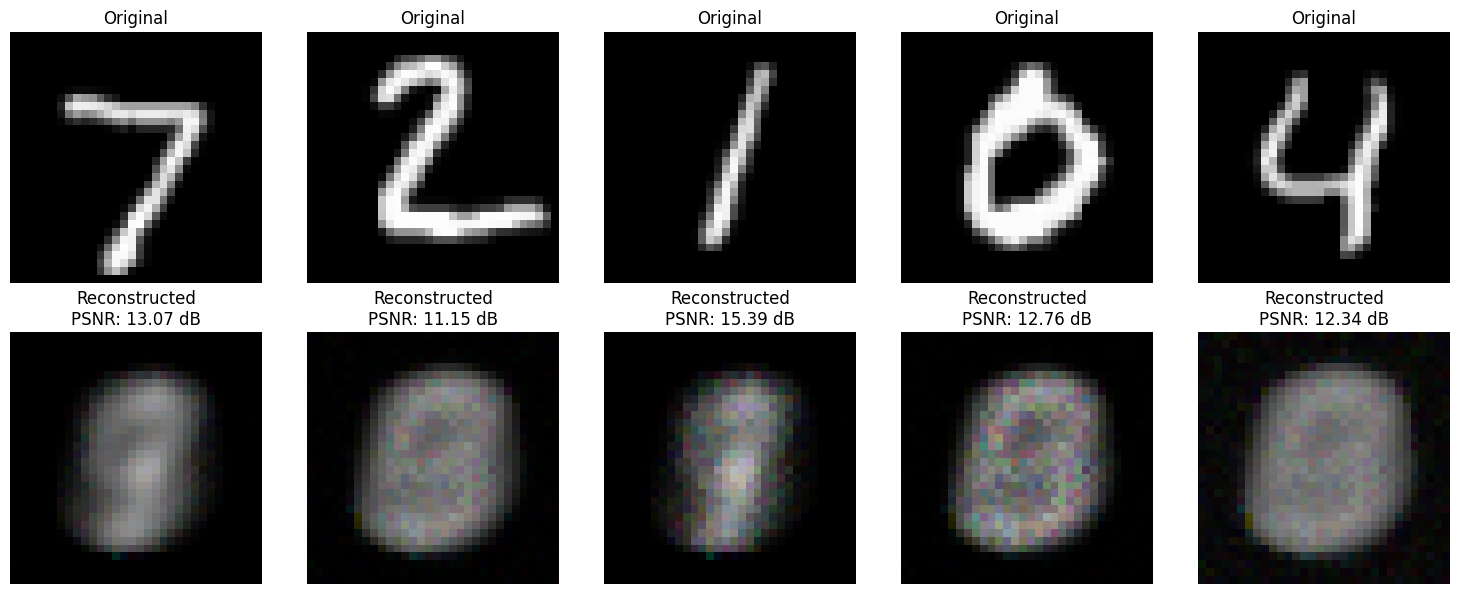

In [9]:
# Set the model to evaluation mode
autoencoder.eval()

# Get predictions for the test set
reconstructed_images = []
original_images = []
with torch.no_grad():
    for images, _ in test_loader:  # Assuming test_loader is defined
        images = images.to(device)
        outputs = autoencoder(images)
        reconstructed_images.append(outputs)
        original_images.append(images)

# Concatenate the batches
reconstructed_images = torch.cat(reconstructed_images)
original_images = torch.cat(original_images)

# Display images before and after reconstruction with PSNR values
display_results(original_images, reconstructed_images)

# Part II

Building the CNN Autoencoder Model
In this section, we will define a Convolutional Neural Network (CNN) Autoencoder using PyTorch. An autoencoder is a type of neural network used to learn efficient representations (encodings) of data, typically for dimensionality reduction or denoising tasks. The CNN Autoencoder consists of two main components: the encoder and the decoder.

- Encoder: This part of the network takes an input image, applies convolutional layers, and reduces the spatial dimensions through pooling operations to extract relevant features.

- Decoder: The decoder takes the encoded features and reconstructs the input image by upsampling through transposed convolutional layers.
The encoder and decoder are designed using PyTorch's nn.Module to build a flexible and modular neural network.

In [10]:
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 32x32x1 -> 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 32x32x32 -> 16x16x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 16x16x32 -> 16x16x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)   # 16x16x64 -> 8x8x64
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8x64 -> 16x16x32
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16x32 -> 32x32x1
            nn.Sigmoid()  # Sigmoid activation to output pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
autoencoder = CNN_Autoencoder().to(device)

summary(autoencoder, input_size=(3, 32, 32))  # For input size of 3x32x32

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
   ConvTranspose2d-7           [-1, 32, 16, 16]          18,464
              ReLU-8           [-1, 32, 16, 16]               0
   ConvTranspose2d-9            [-1, 3, 32, 32]             867
          Sigmoid-10            [-1, 3, 32, 32]               0
Total params: 38,723
Trainable params: 38,723
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.02
Params size (MB): 0.15
Estimated Tot

# Model Compiling

In this step, we define how the model will learn during training by specifying the optimizer, loss function, the hyper-parameters and metrics.

In [11]:
# Hyperparameters
num_epochs = 20  # Number of epochs
batch_size = 64  # Batch size for the DataLoader
learning_rate = 1e-4  # Learning rate for the optimizer
best_checkpoint = './saved_models/cnn_ae_best.pth'  # Path to save the best model

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(best_checkpoint), exist_ok=True)

# Loss function (MSE)
loss_fn = nn.MSELoss()

# Define the optimizer (Adam)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Set up the best validation loss tracking
best_val_loss = float('inf')

Training the CNN Autoencoder

In [12]:
from tqdm import tqdm

# Training loop
for epoch in range(num_epochs):
    # Training phase
    autoencoder.train()
    running_train_loss = 0.0
    running_train_psnr = 0.0
    running_train_ssim = 0.0
    for images, _ in tqdm(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = loss_fn(outputs, images)  # MSE loss
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        running_train_psnr += psnr(images, outputs).item()  # Compute PSNR
        running_train_ssim += compute_ssim(images, outputs)  # Compute SSIM

    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_psnr = running_train_psnr / len(train_loader)
    avg_train_ssim = running_train_ssim / len(train_loader)

    # Validation phase
    autoencoder.eval()
    running_val_loss = 0.0
    running_val_psnr = 0.0
    running_val_ssim = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            outputs = autoencoder(images)
            loss = loss_fn(outputs, images)  # MSE loss
            running_val_loss += loss.item()
            running_val_psnr += psnr(images, outputs).item()  # Compute PSNR
            running_val_ssim += compute_ssim(images, outputs)  # Compute SSIM

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_psnr = running_val_psnr / len(val_loader)
    avg_val_ssim = running_val_ssim / len(val_loader)

    # Print the losses, PSNR, and SSIM for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train PSNR: {avg_train_psnr:.4f}, "
          f"Train SSIM: {avg_train_ssim:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val PSNR: {avg_val_psnr:.4f}, "
          f"Val SSIM: {avg_val_ssim:.4f}")

    # Save the model if the validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(autoencoder.state_dict(), best_checkpoint)  # Save the best model
        print(f"Model saved with validation loss: {avg_val_loss:.4f}")

  0%|          | 0/188 [00:00<?, ?it/s]

100%|██████████| 188/188 [00:50<00:00,  3.72it/s]


Epoch 1/20 - Train Loss: 0.1437, Train PSNR: 8.6848, Train SSIM: 0.0189, Val Loss: 0.0622, Val PSNR: 12.1143, Val SSIM: 0.0737
Model saved with validation loss: 0.0622


100%|██████████| 188/188 [00:47<00:00,  3.96it/s]


Epoch 2/20 - Train Loss: 0.0341, Train PSNR: 15.0193, Train SSIM: 0.1715, Val Loss: 0.0193, Val PSNR: 17.3110, Val SSIM: 0.2953
Model saved with validation loss: 0.0193


  2%|▏         | 3/188 [00:01<01:09,  2.65it/s]


KeyboardInterrupt: 

# Evaluating the Model

In [13]:
# Load the best checkpoint
autoencoder.load_state_dict(torch.load(best_checkpoint))

# Set model to evaluation mode
autoencoder.eval()

# Initialize variables to store the results
test_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0

# Evaluate the model on the test dataset (use test_loader here)
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        # Forward pass
        outputs = autoencoder(images)

        # Compute MSE loss
        loss = nn.MSELoss()(outputs, images)
        test_loss += loss.item()

        # Compute PSNR (Peak Signal-to-Noise Ratio)
        psnr_value = psnr(images, outputs).item()  # Using the psnr function defined earlier
        running_psnr += psnr_value

        # Compute SSIM (Structural Similarity Index)
        ssim_value = compute_ssim(images, outputs)  # Using the compute_ssim function defined earlier
        running_ssim += ssim_value

# Average test loss, PSNR, and SSIM
avg_test_loss = test_loss / len(test_loader)
avg_psnr = running_psnr / len(test_loader)
avg_ssim = running_ssim / len(test_loader)

# Print the evaluation metrics
print(f"Test Loss (MSE): {avg_test_loss:.4f}")
print(f"Overall PSNR: {avg_psnr:.4f}")
print(f"Overall SSIM: {avg_ssim:.4f}")


Test Loss (MSE): 0.0193
Overall PSNR: 17.3120
Overall SSIM: 0.2963


# Visualizing Results

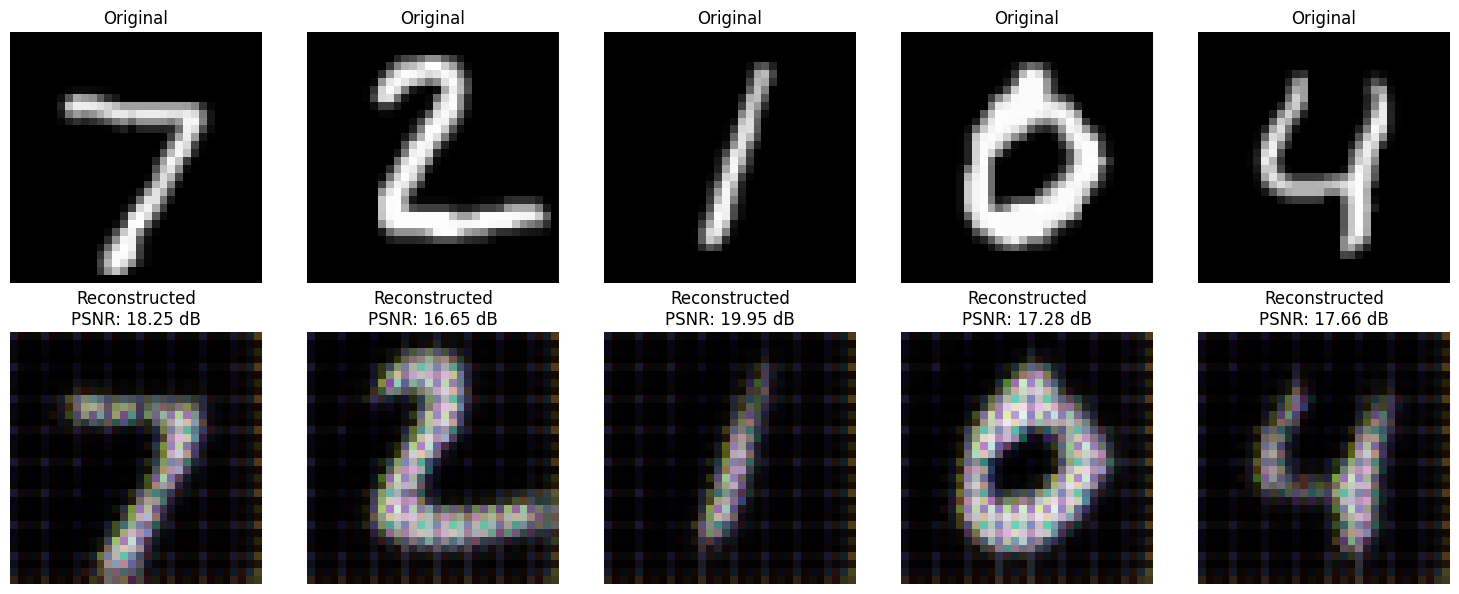

In [14]:
# Set the model to evaluation mode
autoencoder.eval()

# Get predictions for the test set
reconstructed_images = []
original_images = []
with torch.no_grad():
    for images, _ in test_loader:  # Assuming test_loader is defined
        images = images.to(device)
        outputs = autoencoder(images)
        reconstructed_images.append(outputs)
        original_images.append(images)

# Concatenate the batches
reconstructed_images = torch.cat(reconstructed_images)
original_images = torch.cat(original_images)

# Display images before and after reconstruction with PSNR values
display_results(original_images, reconstructed_images)

In [17]:
from model import Model
checkpoint = "path/to/hific/checkpoint.pt"

image_dims = (3, 32, 32)
autoencoder = Model(image_dims=image_dims, checkpoint = checkpoint)
autoencoder = autoencoder.to(device)

ModuleNotFoundError: No module named 'maths'

In [ ]:
def eval_hific(args, model, test_loader, device):

    test_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    
    model.eval()

    idx = 0
    with torch.no_grad():
        for idx, (data, labels) in enumerate(tqdm(test_loader, desc='Val'), 0):

            data = data.to(device, dtype=torch.float)
            reconstruction, loss, ssim_value, psnr_value = model(data)

            test_loss += loss.item()
            running_ssim += ssim_value.item()
            running_psnr += psnr_value.item()

    # Average test loss, PSNR, and SSIM
    avg_test_loss = test_loss / len(test_loader)
    avg_psnr = running_psnr / len(test_loader)
    avg_ssim = running_ssim / len(test_loader)

    # Print the evaluation metrics
    print(f"Test Loss (MSE): {avg_test_loss:.4f}")
    print(f"Overall PSNR: {avg_psnr:.4f}")
    print(f"Overall SSIM: {avg_ssim:.4f}")

In [ ]:
eval_hific(autoencoder, test_loader)

In [ ]:
# Set the model to evaluation mode
autoencoder.eval()

# Get predictions for the test set
reconstructed_images = []
original_images = []
with torch.no_grad():
    for images, _ in test_loader:  # Assuming test_loader is defined
        images = images.to(device)
        outputs = autoencoder(images)
        reconstructed_images.append(outputs)
        original_images.append(images)

# Concatenate the batches
reconstructed_images = torch.cat(reconstructed_images)
original_images = torch.cat(original_images)

# Display images before and after reconstruction with PSNR values
display_results(original_images, reconstructed_images)

ModuleNotFoundError: No module named 'src'

# Conclusion
In this notebook, we:
- Loaded the HiFiC model using TensorFlow Compression library.
- Demonstrated compression and decompression of a sample image.

# You can now experiment further by testing with different images or tuning the model parameters!